In [1]:
!kaggle datasets download -d bettercallbene/lego-classification

/home/appuser/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# %%
#%matplotlib inline
import os

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import matplotlib.pyplot as plt

import random
import cv2

/home/appuser/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %%
dataset_train_name = "lego-classification_train"
# %%
register_coco_instances(dataset_train_name, {}, "./data/train_small.json", "./data/images")

# %%
lego_classificiation_train_metadata = MetadataCatalog.get(dataset_train_name)

dataset_dicts = DatasetCatalog.get(dataset_train_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [3]:
# %%
# dataset_val_name = "lego-classification_valid"
# %%
# register_coco_instances(dataset_val_name, {}, "./data/valid_small.json", "./data/images")

# %%
#MetadataCatalog.get(dataset_val_name)
#dataset_dicts = DatasetCatalog.get(dataset_val_name)

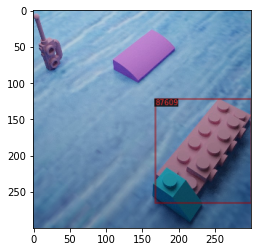

In [4]:
d = random.sample(dataset_dicts, 1)[0]

img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=lego_classificiation_train_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)

plt.imshow(out.get_image()[:, :, ::-1])

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = (dataset_train_name)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 200    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(lego_classificiation_train_metadata.thing_classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.INPUT.MIN_SIZE_TRAIN = (300, 300, 300)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


In [6]:
# %%
from detectron2.engine import DefaultTrainer
import torch
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/18 14:36:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (575, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (575,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (2296, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (2296,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score

[03/18 14:36:21 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/18 14:36:28 d2.utils.events]:  eta: 0:01:08  iter: 19  total_loss: 6.347  loss_cls: 6.271  loss_box_reg: 0.07563  loss_rpn_cls: 0.02268  loss_rpn_loc: 0.002231  time: 0.3816  data_time: 0.0126  lr: 2.3976e-05  max_mem: 4256M
[03/18 14:36:36 d2.utils.events]:  eta: 0:01:00  iter: 39  total_loss: 5.15  loss_cls: 5.037  loss_box_reg: 0.07536  loss_rpn_cls: 0.0181  loss_rpn_loc: 0.001524  time: 0.3815  data_time: 0.0028  lr: 4.8951e-05  max_mem: 4256M
[03/18 14:36:44 d2.utils.events]:  eta: 0:00:53  iter: 59  total_loss: 0.4271  loss_cls: 0.2759  loss_box_reg: 0.05941  loss_rpn_cls: 0.02543  loss_rpn_loc: 0.001952  time: 0.3813  data_time: 0.0027  lr: 7.3926e-05  max_mem: 4256M
[03/18 14:36:51 d2.utils.events]:  eta: 0:00:45  iter: 79  total_loss: 0.3399  loss_cls: 0.2305  loss_box_reg: 0.09669  loss_rpn_cls: 0.01513  loss_rpn_loc: 0.002565  time: 0.3806  data_time: 0.0027  lr: 9.8901e-05  max_mem: 4256M
[03/18 14:36:59 d2.utils.events]:  eta: 0:00:37  iter: 99  total_loss: 0.3154  los

In [5]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir output

/bin/sh: 1: kill: No such process

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11947), started 3 days, 19:48:21 ago. (Use '!kill 11947' to kill it.)

In [7]:
from detectron2.engine import DefaultPredictor


# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

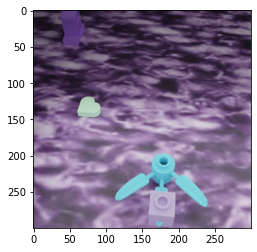

In [8]:
d = random.sample(dataset_dicts, 1)[0]
img = cv2.imread(d['file_name'])
outputs = predictor(img)
visualizer = Visualizer(img[:, :, ::-1], metadata=lego_classificiation_train_metadata, scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])